# CNNs 

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [86]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape # height and width of kernel
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)) # resize (no padding/stride)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum() # this is just indexing and summing over a element-wise kernel application.
    return Y

In [87]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [88]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(1,kernel_size))
        self.bias = nn.Parameter(torch.zeros(1)) # 1 bias bc of space invariance 

    def forward(self, X):
        return corr2d(X,self.weight) + self.bias

In [89]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [90]:
kern = torch.tensor([[1.0,-1.0]])
Y = corr2d(X,kern)
print(corr2d(X,kern), corr2d(X.t(), kern)) # if we fix stuff it is not generalizable :(

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]) tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [91]:
conv2d = Conv2D(kernel_size=2)

lr = 3e-2
for i in range(50):
    yhat = conv2d(X)
    loss = ((yhat - Y)**2).sum()
    conv2d.zero_grad()
    loss.backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad # hell yeah this homebaked version works as well!
    

print(conv2d.weight)

Parameter containing:
tensor([[ 1.0000, -1.0000]], requires_grad=True)


We can learn the above kernel:

In [92]:
conv2d = nn.LazyConv2d(out_channels=1,kernel_size=(1,2),bias=False)

Y = Y.reshape((1, 1, 6, 7))
X = X.reshape((1, 1, 6, 8))
lr = 3e-2  # Learning rate

for i in range(5):
    yhat = conv2d(X)
    loss = ((yhat - Y)**2).sum()
    conv2d.zero_grad()
    loss.backward()

    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    print(f'training epoch {i+1} with loss {loss:.3f}')

print(conv2d.weight)

training epoch 1 with loss 20.280
training epoch 2 with loss 11.278
training epoch 3 with loss 6.521
training epoch 4 with loss 3.888
training epoch 5 with loss 2.372
Parameter containing:
tensor([[[[ 0.7639, -1.0677]]]], requires_grad=True)


In [93]:
def multicorr(X, K):
    return sum(corr2d(x,k) for x,k in zip(X,K)) # zoinks! just sum up all the kernels for the inputs yada yada

X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
            [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

multicorr(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [94]:
def multiOut(X,K): # K is a 4d tensor, a list of tensors for each output, and each output has 3 tensors for each input channel
    # K = a x b x w x h - a outputs, b inputs, kernel is w x h not too bad
    return torch.stack([multicorr(X,k) for k in K], 0) 


K = torch.stack((K, K + 1, K + 2), 0)


multiOut(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 1x1 convolutions
Useful to collapse channels down into output channels + a nonlinear layer makes it wonky donky (can be implemented with matrix multiplications as we have one element corresponding to the scalar kernel for channel c and thing ij by folding X up (or ripping out a dimension whatever look at the code its reshaping and whatnot))


# LeNet 
we can then implement LeNet for FashionMNIST

In [2]:
def init_cnn(module: nn.Module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=(5,5),padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(out_channels=16,kernel_size=5), nn.Sigmoid(), 
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(), 
            nn.LazyLinear(84), nn.Sigmoid(), 
            nn.LazyLinear(self.num_classes))
        

In [96]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


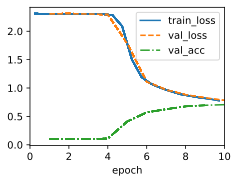

In [97]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## Improving LetNet:
Use ReLu and also MaxPooling instead

In [103]:
class LeNet2(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=(5,5),padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(out_channels=16,kernel_size=5), nn.ReLU(), # this one fucks up the image size
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(), 
            nn.LazyLinear(84), nn.ReLU(), 
            nn.LazyLinear(self.num_classes))

        

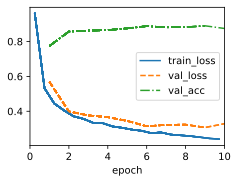

In [104]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet2(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [110]:
class LeNet2(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=(5,5),padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(out_channels=16,kernel_size=5), nn.ReLU(), # this one fucks up the image size
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(), 
            nn.LazyLinear(self.num_classes))

    def configure_optimizers(self):
        return torch.optim.Adam(self.net.parameters(),self.lr)
        

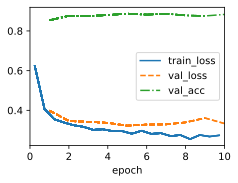

In [112]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet2(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [3]:
class LeNet2(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=16, kernel_size=(5,5),padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(out_channels=32,kernel_size=5), nn.ReLU(), # this one fucks up the image size
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(256), nn.ReLU(),
            nn.LazyLinear(128), nn.ReLU(),  nn.Dropout(p=0.5),
            nn.LazyLinear(self.num_classes))

    def configure_optimizers(self):
        return torch.optim.Adam(self.net.parameters(),self.lr)
        

KeyboardInterrupt: 

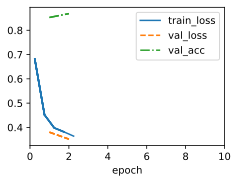

In [4]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet2(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)